# Assessment 02

Eurico Martins (nº. 8794, a8794@alunos.ipca.pt)
Gutelvam Fernandes (nº. 33791,  a33791@alunos.ipca.pt)

In [214]:
%pip install tabulate
%pip install scikit-learn

12663.44s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


12669.46s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


In [215]:
from enum import Enum

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.metrics import confusion_matrix, silhouette_samples
from tabulate import tabulate

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
)


In [216]:
import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

## Data Preparation

In [217]:
class MissingValuesStrategy(Enum):
	MEAN="mean"
	MEDIAN = "median"
	MODE = "mode"
	CONSTANT = "constant"

In [218]:
class DataPreparation:
	def __init__(self, file_path=None, target_column=None):
		if not file_path:
			raise ValueError("Either 'file_path' or 'dataframe' must be provided.")

		self.df = pd.read_csv(file_path)
		self.summary()
		
		self.original_df = self.df.copy(True)
		self.target_column = target_column

		if self.target_column and self.target_column not in self.df.columns:
			raise ValueError(f"Target column '{target_column}' not found in the dataset.")
		

	def drop_columns(self, columns_to_drop):
		if not isinstance(columns_to_drop, list):
				raise ValueError("columns_to_drop should be a list of column names.")

		# Check if any columns in the list do not exist in the DataFrame
		existing_columns = [col for col in columns_to_drop if col in self.df.columns]

		# Drop the columns from the DataFrame
		if existing_columns:
				self.df.drop(columns=existing_columns, inplace=True)
				print(f"Columns {', '.join(existing_columns)} dropped successfully.")



	def handle_missing_values(self, strategy:MissingValuesStrategy = MissingValuesStrategy.MEAN, fill_value=None):
		for column in self.df.columns:
			if self.df[column].isnull().sum() > 0:
				if strategy == MissingValuesStrategy.MEAN and self.df[column].dtype in ["float64", "int64"]:
					self.df[column].fillna(self.df[column].mean(), inplace=True)
				elif strategy == MissingValuesStrategy.MEDIAN and self.df[column].dtype in ["float64", "int64"]:
					self.df[column].fillna(self.df[column].median(), inplace=True)
				elif strategy == MissingValuesStrategy.MODE:
					self.df[column].fillna(self.df[column].mode()[0], inplace=True)
				elif strategy == MissingValuesStrategy.CONSTANT:
					self.df[column].fillna(fill_value, inplace=True)

	def encode_categorical(self):
		self.label_encoders = {}
		for column in self.df.select_dtypes(include=["object", "category"]).columns:
			le = LabelEncoder()
			self.df[column] = le.fit_transform(self.df[column])
			self.label_encoders[column] = le

	def get_features_and_target(self):
		if not self.target_column:
			raise ValueError("Target column is not specified.")
		X = self.df.drop(columns=[self.target_column])
		y = self.df[self.target_column]
		return X, y


	def scale_features(self):
		columns = self.df.select_dtypes(include=["float64", "int64"]).columns

		scaler = StandardScaler()
		self.df[columns] = scaler.fit_transform(self.df[columns])


	def remove_outliers(self, columns=None, factor=1.5, threshold=3):
		if columns is None:
			columns = self.df.select_dtypes(include=["float64", "int64"]).columns
		
		# Determine if the data is skewed or normal
		skewed_columns = self._detect_distribution(columns)
		if skewed_columns:
				print(f"Using IQR method for skewed columns: {skewed_columns}")
				rows_removed = self._remove_outliers_iqr(columns=skewed_columns, factor=factor)
		else:
				print("Using Z-score method for normally distributed columns.")
				rows_removed = self._remove_outliers_zscore(columns=columns, threshold=threshold)

		print(f"Rows removed: {rows_removed}")

	def remove_duplicates(self, subset=None, keep="first"):
		rows_before = len(self.df)
		self.df.drop_duplicates(subset=subset, keep=keep, inplace=True)
		rows_after = len(self.df)

		removed_rows = rows_before - rows_after
		print(f"Rows removed due to duplicates: {removed_rows}")
		return removed_rows


	def plot_distributions(self):
		# Distribution plots for numerical features
		numerical_columns = self.df.select_dtypes(include=["float64", "int64"]).columns
		n_cols = 3  # Number of plots in each row
		n_rows = (len(numerical_columns) // n_cols) + (1 if len(numerical_columns) % n_cols else 0)

		# Adjust the plot size
		plt.figure(figsize=(12, 4 * n_rows))
		for idx, column in enumerate(numerical_columns):
				plt.subplot(n_rows, n_cols, idx + 1)
				sns.histplot(self.df[column], kde=True, bins=30)
				plt.title(f'Distribution of {column}')
		# Apply tight layout for better spacing
		plt.tight_layout()
		plt.show()

	def normality_test_with_plots(self, columns=None):
		# Select all numerical columns if `columns` is None
		if columns is None:
			columns = self.df.select_dtypes(include=["int64", "float64"]).columns

		# Check if no columns are available for testing
		if columns.empty:
			print("No numerical columns to test.")
			return

		# Loop through each column
		for column in columns:
			print(f"\nNormality Tests for Column: {column}")

			# Perform Shapiro-Wilk Test
			stat_shapiro, p_value_shapiro = stats.shapiro(self.df[column].dropna())
			print(f"Shapiro-Wilk Test: statistic={stat_shapiro:.4f}, p-value={p_value_shapiro:.4f}")

			# Perform Kolmogorov-Smirnov Test
			stat_ks, p_value_ks = stats.kstest(
					self.df[column].dropna(), 
					'norm', 
					args=(self.df[column].mean(), self.df[column].std())
			)
			print(f"Kolmogorov-Smirnov Test: statistic={stat_ks:.4f}, p-value={p_value_ks:.4f}")

			# Calculate statistics
			mean_val = self.df[column].mean()
			median_val = self.df[column].median()
			mode_val = self.df[column].mode().iloc[0] if not self.df[column].mode().empty else None

			# Create subplots (1 row, 3 columns)
			_, axes = plt.subplots(1, 3, figsize=(18, 6))

			# Plot Histogram and KDE
			sns.histplot(self.df[column], kde=True, color='blue', bins=30, ax=axes[0], stat="density")
			axes[0].axvline(mean_val, color='red', linestyle='--', label=f"Mean: {mean_val:.2f}")
			axes[0].axvline(median_val, color='green', linestyle='--', label=f"Median: {median_val:.2f}")
			if mode_val is not None:
					axes[0].axvline(mode_val, color='purple', linestyle='--', label=f"Mode: {mode_val:.2f}")
			axes[0].legend()
			axes[0].set_title(f"Histogram and KDE of {column}", fontsize=14)
			axes[0].set_xlabel(column, fontsize=12)
			axes[0].set_ylabel("Density", fontsize=12)

			# Q-Q Plot
			stats.probplot(self.df[column].dropna(), dist="norm", plot=axes[1])
			axes[1].set_title(f"Q-Q Plot of {column}", fontsize=14)

			# Boxplot
			sns.boxplot(x=self.df[column], color='orange', ax=axes[2])
			axes[2].axvline(mean_val, color='red', linestyle='--', label=f"Mean: {mean_val:.2f}")
			axes[2].axvline(median_val, color='green', linestyle='--', label=f"Median: {median_val:.2f}")
			if mode_val is not None:
					axes[2].axvline(mode_val, color='purple', linestyle='--', label=f"Mode: {mode_val:.2f}")
			axes[2].legend()
			axes[2].set_title(f"Boxplot of {column}", fontsize=14)
			axes[2].set_xlabel(column, fontsize=12)

			# Adjust layout to avoid overlap
			plt.tight_layout()
			plt.show()

	def plot_correlation_matrix(self, columns=None, annot=True, cmap="coolwarm"):
		if columns is None:
			columns = self.df.select_dtypes(include=["float64", "int64"]).columns
		
		# Calculate the correlation matrix
		correlation_matrix = self.df[columns].corr()

		plt.figure(figsize=(10, 6))
		sns.heatmap(correlation_matrix, annot=annot, cmap=cmap, fmt='.2f', linewidths=0.5, cbar=True)
		plt.title("Correlation Matrix")
		plt.show()

	def normality_test(self, columns=None):
		if columns is None:
			columns = self.df.select_dtypes(include=["float64", "int64"]).columns
		
		for column in columns:
			stat_shapiro, p_value_shapiro = stats.shapiro(self.df[column].dropna())
			print(f"Shapiro-Wilk Test for {column}: stat={stat_shapiro}, p-value={p_value_shapiro}")

			stat_ks, p_value_ks = stats.kstest(self.df[column].dropna(), 'norm', args=(self.df[column].mean(), self.df[column].std()))
			print(f"Kolmogorov-Smirnov Test for {column}: stat={stat_ks}, p-value={p_value_ks}")

			# Plot histogram with KDE and normal distribution fit for visual inspection
			plt.figure(figsize=(10, 6))
			sns.histplot(self.df[column], kde=True, bins=30, color='blue', stat="density")
			min_value, max_value = self.df[column].min(), self.df[column].max()
			x = np.linspace(min_value, max_value, 100)
			y = stats.norm.pdf(x, loc=self.df[column].mean(), scale=self.df[column].std())
			plt.plot(x, y, color='red', label='Normal Distribution Fit')
			plt.title(f'{column} Distribution with Normality Test')
			plt.legend()
			plt.show()


	def compare_histograms(self):
			# Original data vs current data (after processing)
			numerical_columns = self.df.select_dtypes(include=["float64", "int64"]).columns
			for column in numerical_columns:
					plt.figure(figsize=(10, 6))
					sns.histplot(self.original_df[column], kde=True, color='blue', label='Original Data', bins=30)
					sns.histplot(self.df[column], kde=True, color='red', label='Processed Data', bins=30)
					plt.legend()
					plt.title(f'Comparison of {column} Histogram: Original vs Processed')
					plt.show()

	def compare_data_state(self, columns=None, bins=20, use_kde=False):
			# If no columns are provided, use all numerical columns
			if columns is None:
				columns = self.df.select_dtypes(include=["int64", "float64"]).columns

			# Create subplots (number of rows based on the number of columns)
			_, axes = plt.subplots(len(columns), 2, figsize=(10, 4 * len(columns)))
			
			if len(columns) == 1:
				axes = np.expand_dims(axes, axis=0)  # Ensure axes is 2D if only one column
			
			# Loop through each specified column
			for idx, column in enumerate(columns):
				# Plot original data
				sns.histplot(self.original_df[column], kde=use_kde, color='blue', label='Original Data', bins=bins, ax=axes[idx, 0])
				axes[idx, 0].set_title(f"Original {column}")
				axes[idx, 0].set_xlabel(column)
				axes[idx, 0].set_ylabel('Density')
				axes[idx, 0].legend()

				# Plot processed data
				sns.histplot(self.df[column], kde=use_kde, color='red', label='Processed Data', bins=bins, ax=axes[idx, 1])
				axes[idx, 1].set_title(f"Processed {column}")
				axes[idx, 1].set_xlabel(column)
				axes[idx, 1].set_ylabel('Density')
				axes[idx, 1].legend()

			# Adjust layout to avoid overlap
			plt.tight_layout()
			plt.show()


	def summary(self, num_rows=3):
		# Create the summary DataFrame
		summ = pd.DataFrame(self.df.dtypes, columns=['Data Type'])
		summ['Missing#'] = self.df.isna().sum()
		summ['Missing%'] = (self.df.isna().sum()) / len(self.df)
		summ['Dups'] = [self.df.duplicated().sum()] * len(summ)
		summ['Uniques'] = self.df.nunique().values
		summ['Count'] = self.df.count().values

		# Include statistical descriptions
		desc = pd.DataFrame(self.df.describe(include='all').transpose())
		summ['Min'] = desc.get('min', np.nan).values
		summ['Max'] = desc.get('max', np.nan).values
		summ['Average'] = desc.get('mean', np.nan).values
		summ['Standard Deviation'] = desc.get('std', np.nan).values

		# Dynamically include the specified number of row values
		for idx in range(num_rows):
			if idx < len(self.df):
				summ[f"Value Row {idx+1}"] = self.df.iloc[idx].values
			else:
				summ[f"Value Row {idx+1}"] = [np.nan] * len(summ)

		# Display the summary DataFrame
		display(summ)

	def _detect_distribution(self, columns=None):
		if columns is None:
				columns = self.df.select_dtypes(include=["float64", "int64"]).columns

		# Check for skewness in the data to decide the method
		skewness = self.df[columns].skew()
		skewed_columns = skewness[skewness.abs() > 0.5].index.tolist()
		return skewed_columns
	
	def _remove_outliers_iqr(self, columns=None, factor=1.5):
		if columns is None:
			columns = self.df.select_dtypes(include=["float64", "int64"]).columns

		rows_before = len(self.df)
		for column in columns:
			Q1 = self.df[column].quantile(0.25)
			Q3 = self.df[column].quantile(0.75)
			IQR = Q3 - Q1
			lower_bound = Q1 - factor * IQR
			upper_bound = Q3 + factor * IQR
			self.df = self.df[(self.df[column] >= lower_bound) & (self.df[column] <= upper_bound)]
		rows_after = len(self.df)

		removed_rows = rows_before - rows_after
		return removed_rows

	def _remove_outliers_zscore(self, columns=None, threshold=3):
		if columns is None:
			columns = self.df.select_dtypes(include=["float64", "int64"]).columns

		rows_before = len(self.df)
		z_scores = np.abs(stats.zscore(self.df[columns]))
		self.df = self.df[(z_scores < threshold).all(axis=1)]
		rows_after = len(self.df)

		removed_rows = rows_before - rows_after
		return removed_rows

## PipeLine Object Definition

In [219]:
class LearningType(Enum):
    SUPERVISED = "supervised"
    UNSUPERVISED = "unsupervised"


class TargetMetric(Enum):
    RMSE = "rmse"
    MSE = "mse"
    MAE = "mae"
    R2 = "r2"
    ACCURACY = "accuracy"
    SILHOUETTE = "silhouette"
    PRECISION = "precision"
    RECALL = "recall"

In [220]:
class AutoMLPipeline:
	def __init__(self, learning_type: LearningType, target_metric: TargetMetric):
		if not isinstance(learning_type, LearningType):
				raise ValueError("learning_type must be an instance of LearningType Enum.")
		if not isinstance(target_metric, TargetMetric):
				raise ValueError("target_metric must be an instance of TargetMetric Enum.")
		
		# Validate that the metric is appropriate for the learning type
		valid_metrics = {
				LearningType.SUPERVISED: {
						TargetMetric.RMSE,
						TargetMetric.MSE,
						TargetMetric.MAE,
						TargetMetric.R2,
						TargetMetric.ACCURACY,
						TargetMetric.PRECISION,
						TargetMetric.RECALL,
				},
				LearningType.UNSUPERVISED: {
						TargetMetric.SILHOUETTE,
				},
		}
		
		if target_metric not in valid_metrics[learning_type]:
				raise ValueError(
						f"Invalid target metric '{target_metric.name}' for learning type '{learning_type.name}'. "
						f"Valid metrics for {learning_type.name} are: "
						f"{', '.join(metric.name for metric in valid_metrics[learning_type])}."
				)
		
		self.learning_type = learning_type
		self.target_metric = target_metric

		self.pipeline = None

		self.best_model = None
		self.results = {}


	def train(self, x, y):
		if self.learning_type == LearningType.SUPERVISED and y is None:
			raise ValueError("y is required for supervised learning.")

		numeric_features = x.select_dtypes(include=["int64", "float64"]).columns.tolist()
		categorical_features = x.select_dtypes(include=["object", "category"]).columns.tolist()

		if self.learning_type == LearningType.SUPERVISED:
			self._train_supervised(x, y,numeric_features, categorical_features)


	def report(self):
		if not self.results:
				raise ValueError("No results available. Train the models first.")

		# Convert results dictionary to a DataFrame
		results_data = []
		for model_name, result in self.results.items():
				results_data.append({
						"Model": model_name,
						"Score": result["score"]  # Explicitly extract the "score"
				})
		results_df = pd.DataFrame(results_data)

		# Add a Rank column based on scores
		results_df["Rank"] = results_df["Score"].rank(ascending=(self.target_metric != TargetMetric.R2))
		results_df = results_df.sort_values(by="Rank", ascending=True)

		# Enhanced Summary Table
		print("\nModel Performance Summary:")
		print(results_df)

		# Plot model performance comparison
		plt.figure(figsize=(10, 6))
		sns.barplot(x="Score", y="Model", data=results_df, palette="viridis")
		plt.title(f"Model Performance Comparison ({self.target_metric.name})", fontsize=16)
		plt.xlabel("Score", fontsize=14)
		plt.ylabel("Model", fontsize=14)
		plt.tight_layout()
		plt.show()

		# Details for the best model
		best_model_name = results_df.iloc[0]["Model"]
		best_model_score = results_df.iloc[0]["Score"]
		print(f"\nBest Model: {best_model_name} with Score: {best_model_score:.4f}")

		# Additional visualizations and metrics
		if self.learning_type == LearningType.SUPERVISED:
				self._report_supervised()
		elif self.learning_type == LearningType.UNSUPERVISED:
				self._report_unsupervised()



	def _create_pipeline(self, model, numeric_features, categorical_features):
		# Define transformers for numeric and categorical data
		numeric_transformer = Pipeline(steps=[
				("scaler", StandardScaler())
		])
		categorical_transformer = Pipeline(steps=[
				("onehot", OneHotEncoder(handle_unknown="ignore"))
		])
		
		# Create a preprocessor for column transformations
		preprocessor = ColumnTransformer(
				transformers=[
						("num", numeric_transformer, numeric_features),
						("cat", categorical_transformer, categorical_features),
				]
		)
		
		# Create the full pipeline
		self.pipeline = Pipeline(steps=[
				("preprocessor", preprocessor),
				("model", model)
		])


	def _train_supervised(self, x, y, numeric_features, categorical_features):
		if self.learning_type == LearningType.SUPERVISED:
			models = [
				("Random Forest", RandomForestRegressor() if self.target_metric in {TargetMetric.RMSE, TargetMetric.MSE, TargetMetric.MAE, TargetMetric.R2} else RandomForestClassifier(), {
					"model__n_estimators": randint(10, 200),
					"model__max_depth": randint(3, 20),
				}),
				("Linear/Logistic Regression", LinearRegression() if self.target_metric in {TargetMetric.RMSE, TargetMetric.MSE, TargetMetric.MAE, TargetMetric.R2} else LogisticRegression(), {}),
				("Decision Tree", DecisionTreeRegressor() if self.target_metric in {TargetMetric.RMSE, TargetMetric.MSE, TargetMetric.MAE, TargetMetric.R2} else DecisionTreeClassifier(), {
					"model__max_depth": randint(3, 20),
					"model__min_samples_split": randint(2, 10),
					"model__min_samples_leaf": randint(1, 5),
				}),
				("Support Vector Machine", SVR() if self.target_metric in {TargetMetric.RMSE, TargetMetric.MSE, TargetMetric.MAE, TargetMetric.R2} else SVC(probability=True), {
					"model__C": uniform(0.1, 10),
					"model__gamma": uniform(0.01, 1),
				}),
			]
			x_train, self.x_test, y_train, self.y_test = train_test_split(x, y, test_size=0.2, random_state=42)

			best_score = -np.inf if self.target_metric == TargetMetric.R2 else np.inf
			for name, model, param_grid in models:
				# Create the pipeline
				self._create_pipeline(model, numeric_features, categorical_features)

				# Define the scorer based on the target metric
				scorer = None
				match self.target_metric:
					case TargetMetric.RMSE:
						scorer = "neg_root_mean_squared_error"
					case TargetMetric.MSE:
						scorer = "neg_mean_squared_error"
					case TargetMetric.MAE:
						scorer = "neg_mean_absolute_error"
					case TargetMetric.R2:
						scorer = "r2"
					case TargetMetric.ACCURACY:
						scorer = "accuracy"
					case TargetMetric.PRECISION:
						scorer = "precision_weighted"
					case TargetMetric.RECALL:
						scorer = "recall_weighted"

				# Perform randomized search
				search = RandomizedSearchCV(
					self.pipeline,
					param_distributions=param_grid,
					scoring=scorer,
					cv=5,
					n_iter=10,
					random_state=42,
					n_jobs=-1,
				)
				search.fit(x_train, y_train)

				# Retrieve the best pipeline and score
				best_pipeline = search.best_estimator_
				score = search.best_score_

				self.results[name] = {
					"pipeline": best_pipeline,
					"score": score
				}

				# Update the best model
				if (self.target_metric == TargetMetric.R2 and score > best_score) or (self.target_metric != TargetMetric.R2 and score < best_score):
					best_score = score
					self.best_model = best_pipeline
				


	def _report_supervised(self):
		if self.x_test is None or self.y_test is None:
			raise ValueError("Test data not found. Ensure the train method has been executed.")

		fig, axes = plt.subplots(len(self.results), 2, figsize=(14, 6 * len(self.results)))
		fig.suptitle("Model Comparison: Real vs Predicted and Residuals", fontsize=18)

		for idx, (model_name, result) in enumerate(self.results.items()):
			# Get the model pipeline
			model_pipeline = result["pipeline"]

			# Predict using the pipeline
			y_pred = model_pipeline.predict(self.x_test)

			# Metrics for the model
			score = result["score"]
			print(f"\nModel: {model_name} | Score: {score:.4f}")

			# Real vs Predicted Plot
			ax1 = axes[idx, 0]
			ax1.scatter(range(len(self.y_test)), self.y_test, color="blue", label="Real", alpha=0.7)
			ax1.scatter(range(len(self.y_test)), y_pred, color="orange", label="Predicted", alpha=0.7)
			ax1.set_title(f"{model_name}: Real vs Predicted", fontsize=14)
			ax1.set_xlabel("Samples", fontsize=12)
			ax1.set_ylabel("Values", fontsize=12)
			ax1.legend()

			# Residual Plot
			residuals = self.y_test - y_pred
			ax2 = axes[idx, 1]
			ax2.scatter(range(len(self.y_test)), residuals, color="purple", alpha=0.7)
			ax2.axhline(0, color="red", linestyle="--", linewidth=1.5)
			ax2.set_title(f"{model_name}: Residuals", fontsize=14)
			ax2.set_xlabel("Samples", fontsize=12)
			ax2.set_ylabel("Residuals", fontsize=12)

		plt.tight_layout(rect=[0, 0, 1, 0.97])
		plt.show()


	def _report_unsupervised(self):
		x_transformed = self.best_model.named_steps["preprocessor"].transform(self.best_model.named_steps["model"].data_)
		labels = self.best_model.predict(x_transformed)

		# Silhouette Coefficient Distribution
		silhouette_vals = silhouette_samples(x_transformed, labels)
		plt.figure(figsize=(10, 6))
		sns.histplot(silhouette_vals, kde=True, bins=30, color="blue")
		plt.title("Silhouette Coefficients Distribution", fontsize=16)
		plt.xlabel("Silhouette Coefficient", fontsize=14)
		plt.ylabel("Frequency", fontsize=14)
		plt.tight_layout()
		plt.show()

		# Cluster Visualization (optional, works with 2D data)
		if x_transformed.shape[1] == 2:  # Only visualize if data is 2D
			plt.figure(figsize=(10, 6))
			sns.scatterplot(x=x_transformed[:, 0], y=x_transformed[:, 1], hue=labels, palette="viridis", s=50)
			plt.title("Cluster Visualization", fontsize=16)
			plt.xlabel("Feature 1", fontsize=14)
			plt.ylabel("Feature 2", fontsize=14)
			plt.legend(title="Cluster", loc="best")
			plt.tight_layout()
			plt.show()

## Main

DataBase loading and metadata display

In [221]:
airbnb_data_prep:DataPreparation = DataPreparation("../data/learning/airbnb_lisbon/airbnb_lisbon_1480_2017-07-27.csv", target_column="price")

,Data Type,Missing#,Missing%,Dups,Uniques,Count,Min,Max,Average,Standard Deviation,Value Row 1,Value Row 2,Value Row 3
room_id,int64,0,0.000000,0,13578,13578,6499.0,20091030.0,11286530.758285,6331112.119502,14708916,7465447,11058290
survey_id,int64,0,0.000000,0,1,13578,1480.0,1480.0,1480.0,0.0,1480,1480,1480
host_id,int64,0,0.000000,0,6457,13578,14455.0,142658216.0,40317799.948814,41202576.060598,91501272,704061,1379661
room_type,object,0,0.000000,0,3,13578,NaN,NaN,NaN,NaN,Shared room,Shared room,Shared room
country,float64,13578,1.000000,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,object,0,0.000000,0,1,13578,NaN,NaN,NaN,NaN,Lisbon,Lisbon,Lisbon
borough,float64,13578,1.000000,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighborhood,object,0,0.000000,0,24,13578,NaN,NaN,NaN,NaN,Santo António,Avenidas Novas,Santa Maria Maior
reviews,int64,0,0.000000,0,276,13578,0.0,448.0,29.507512,43.657402,19,4,38
overall_satisfaction,float64,0,0.000000,0,9,13578,0.0,5.0,3.242046,2.151046,4.5,3.5,4.5


In [222]:
airbnb_data_prep.encode_categorical()
airbnb_data_prep.summary()

,Data Type,Missing#,Missing%,Dups,Uniques,Count,Min,Max,Average,Standard Deviation,Value Row 1,Value Row 2,Value Row 3
room_id,int64,0,0.0,0,13578,13578,6499.000000,2.009103e+07,1.128653e+07,6.331112e+06,1.470892e+07,7.465447e+06,1.105829e+07
survey_id,int64,0,0.0,0,1,13578,1480.000000,1.480000e+03,1.480000e+03,0.000000e+00,1.480000e+03,1.480000e+03,1.480000e+03
host_id,int64,0,0.0,0,6457,13578,14455.000000,1.426582e+08,4.031780e+07,4.120258e+07,9.150127e+07,7.040610e+05,1.379661e+06
room_type,int64,0,0.0,0,3,13578,0.000000,2.000000e+00,2.792753e-01,4.748199e-01,2.000000e+00,2.000000e+00,2.000000e+00
country,float64,13578,1.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,int64,0,0.0,0,1,13578,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
borough,float64,13578,1.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighborhood,int64,0,0.0,0,24,13578,0.000000,2.300000e+01,1.400110e+01,6.937791e+00,2.100000e+01,5.000000e+00,2.000000e+01
reviews,int64,0,0.0,0,276,13578,0.000000,4.480000e+02,2.950751e+01,4.365740e+01,1.900000e+01,4.000000e+00,3.800000e+01
overall_satisfaction,float64,0,0.0,0,9,13578,0.000000,5.000000e+00,3.242046e+00,2.151046e+00,4.500000e+00,3.500000e+00,4.500000e+00


In [223]:
airbnb_data_prep.drop_columns([
	"survey_id",
	"host_id",
	"room_id",
	"last_modified",
	"name",
	"country",
	"city",
	"borough",
	"bathrooms",
	"minstay"
])

airbnb_data_prep.remove_outliers()
airbnb_data_prep.remove_duplicates(subset=None, keep="first")
airbnb_data_prep.handle_missing_values(MissingValuesStrategy.MEAN)

airbnb_data_prep.summary()
# airbnb_data_prep.scale_features()



Columns survey_id, host_id, room_id, last_modified, name, country, city, borough, bathrooms, minstay dropped successfully.
Using IQR method for skewed columns: ['room_type', 'reviews', 'overall_satisfaction', 'accommodates', 'bedrooms', 'price', 'latitude', 'longitude']
Rows removed: 3516
Rows removed due to duplicates: 0


,Data Type,Missing#,Missing%,Dups,Uniques,Count,Min,Max,Average,Standard Deviation,Value Row 1,Value Row 2,Value Row 3
room_type,int64,0,0.0,0,3,10062,0.000000,2.000000,0.301928,0.486447,2.000000,2.000000,2.000000
neighborhood,int64,0,0.0,0,16,10062,1.000000,23.000000,14.309282,6.885229,21.000000,5.000000,20.000000
reviews,int64,0,0.0,0,99,10062,0.000000,98.000000,20.926555,24.761213,19.000000,4.000000,38.000000
overall_satisfaction,float64,0,0.0,0,9,10062,0.000000,5.000000,3.248658,2.139466,4.500000,3.500000,4.500000
accommodates,int64,0,0.0,0,9,10062,1.000000,9.000000,3.493043,1.640453,4.000000,6.000000,8.000000
bedrooms,float64,0,0.0,0,4,10062,0.000000,3.000000,1.350229,0.723867,1.000000,1.000000,1.000000
price,float64,0,0.0,0,139,10062,10.000000,171.000000,69.504870,32.342497,30.000000,39.000000,39.000000
latitude,float64,0,0.0,0,8393,10062,38.696760,38.750080,38.719131,0.009845,38.723987,38.735061,38.715726
longitude,float64,0,0.0,0,8853,10062,-9.177922,-9.106148,-9.141522,0.011658,-9.146613,-9.154510,-9.132671
location,int64,0,0.0,0,10062,10062,0.000000,13576.000000,6820.757702,3919.844434,3381.000000,4694.000000,4671.000000


In [224]:
airbnb_data_prep.scale_features()
airbnb_data_prep.summary()

,Data Type,Missing#,Missing%,Dups,Uniques,Count,Min,Max,Average,Standard Deviation,Value Row 1,Value Row 2,Value Row 3
room_type,float64,0,0.0,0,3,10062,-0.620711,3.490937,1.355836e-16,1.00005,3.490937,3.490937,3.490937
neighborhood,float64,0,0.0,0,16,10062,-1.933116,1.262289,-1.016877e-16,1.00005,0.971798,-1.352133,0.826552
reviews,float64,0,0.0,0,99,10062,-0.845177,3.112823,5.649316e-18,1.00005,-0.077809,-0.683626,0.689558
overall_satisfaction,float64,0,0.0,0,9,10062,-1.518519,0.818629,4.519453e-17,1.00005,0.584914,0.117485,0.584914
accommodates,float64,0,0.0,0,9,10062,-1.519804,3.357140,0.000000e+00,1.00005,0.309050,1.528286,2.747522
bedrooms,float64,0,0.0,0,4,10062,-1.865392,2.279222,-1.129863e-16,1.00005,-0.483854,-0.483854,-0.483854
price,float64,0,0.0,0,139,10062,-1.839927,3.138291,-4.519453e-17,1.00005,-1.221515,-0.943229,-0.943229
latitude,float64,0,0.0,0,8393,10062,-2.272385,3.143775,2.620831e-13,1.00005,0.493290,1.618169,-0.345849
longitude,float64,0,0.0,0,8853,10062,-3.122378,3.034323,-1.466562e-13,1.00005,-0.436724,-1.114120,0.759207
location,float64,0,0.0,0,10062,10062,-1.740145,1.723430,-6.143631e-17,1.00005,-0.877568,-0.542589,-0.548457



Normality Tests for Column: room_type
Shapiro-Wilk Test: statistic=0.5945, p-value=0.0000
Kolmogorov-Smirnov Test: statistic=0.4436, p-value=0.0000


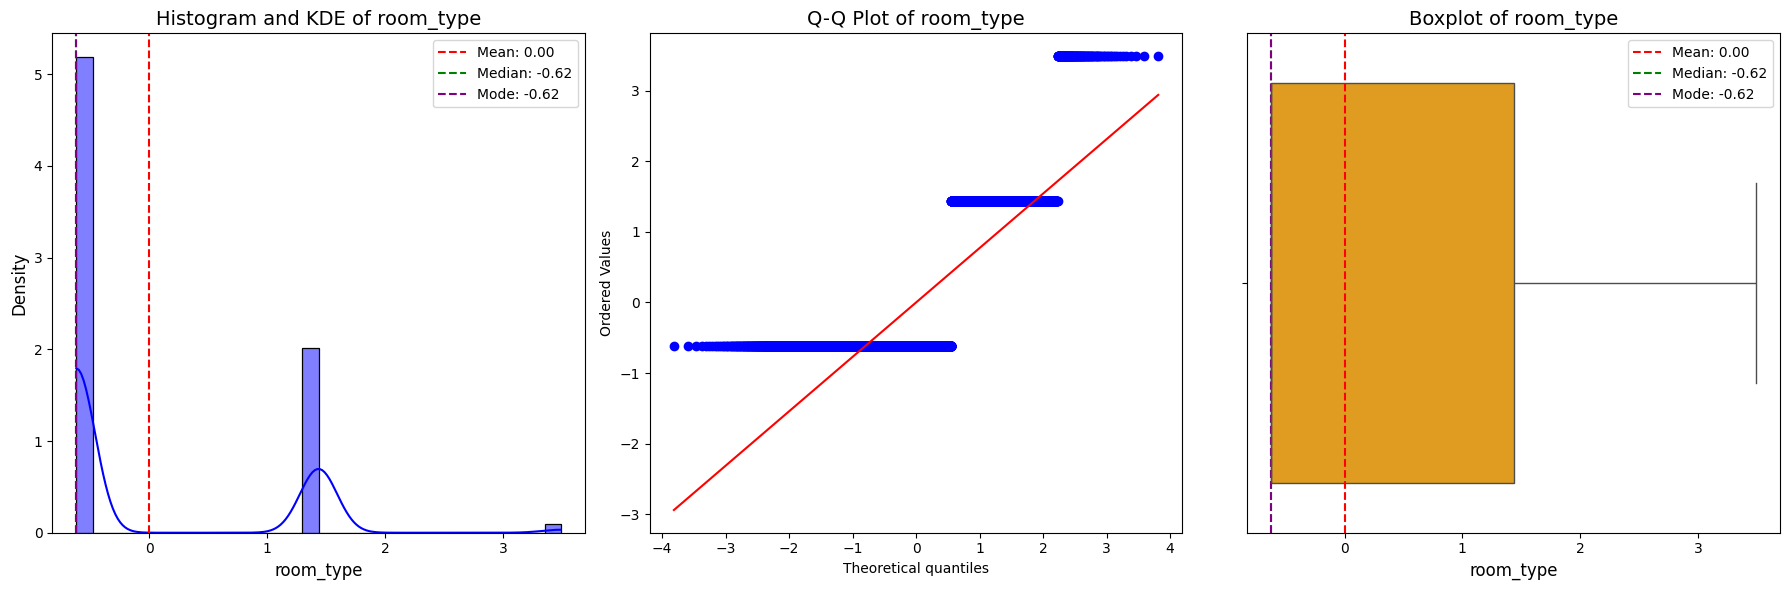


Normality Tests for Column: neighborhood
Shapiro-Wilk Test: statistic=0.8673, p-value=0.0000
Kolmogorov-Smirnov Test: statistic=0.2032, p-value=0.0000


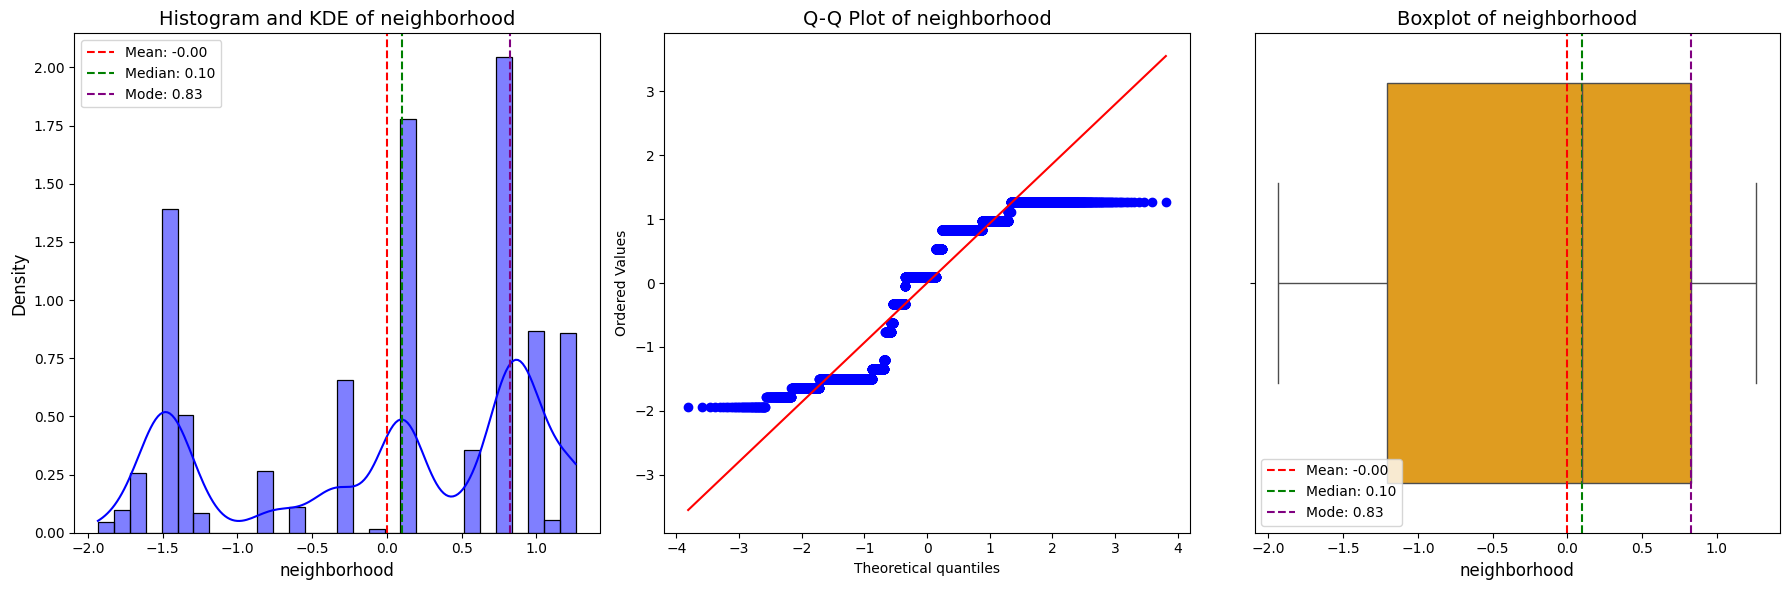


Normality Tests for Column: reviews
Shapiro-Wilk Test: statistic=0.8086, p-value=0.0000
Kolmogorov-Smirnov Test: statistic=0.1990, p-value=0.0000


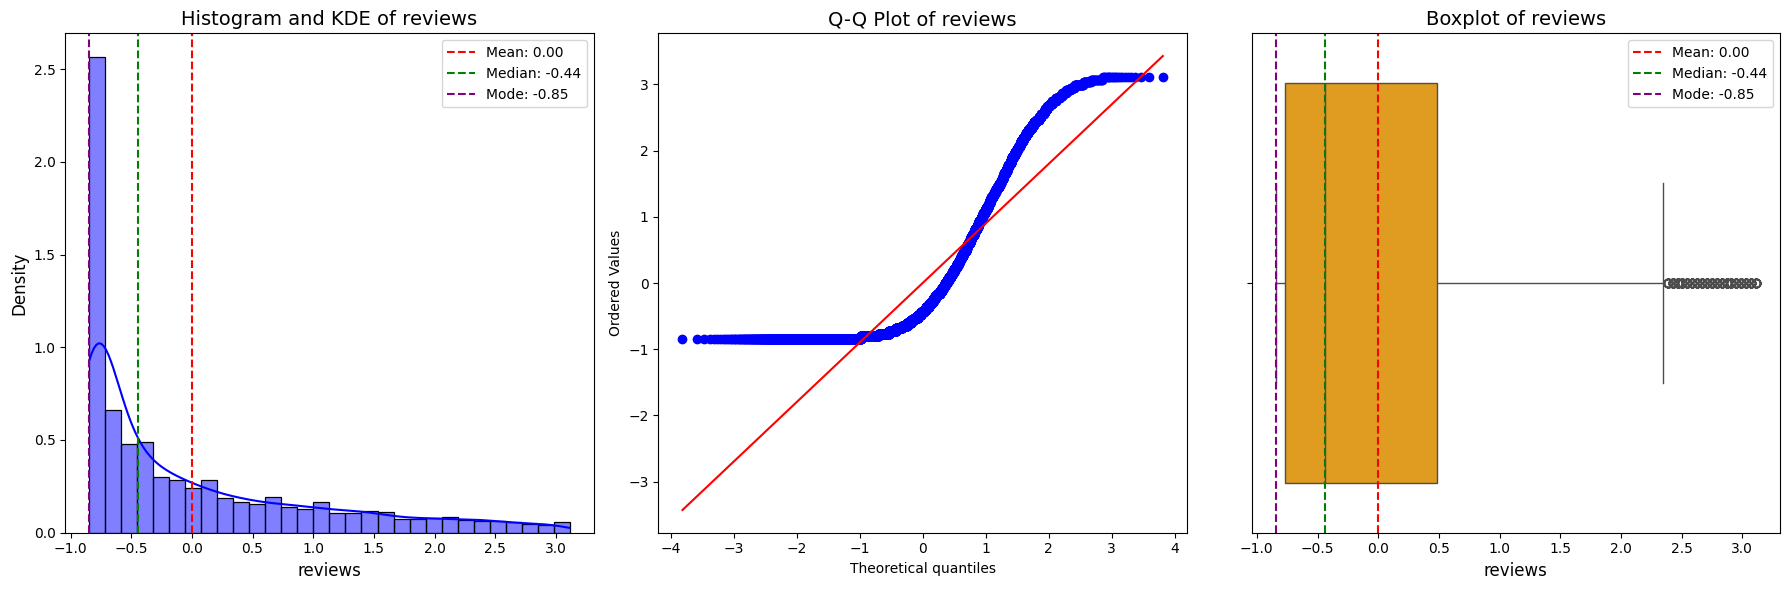


Normality Tests for Column: overall_satisfaction
Shapiro-Wilk Test: statistic=0.6694, p-value=0.0000
Kolmogorov-Smirnov Test: statistic=0.3410, p-value=0.0000


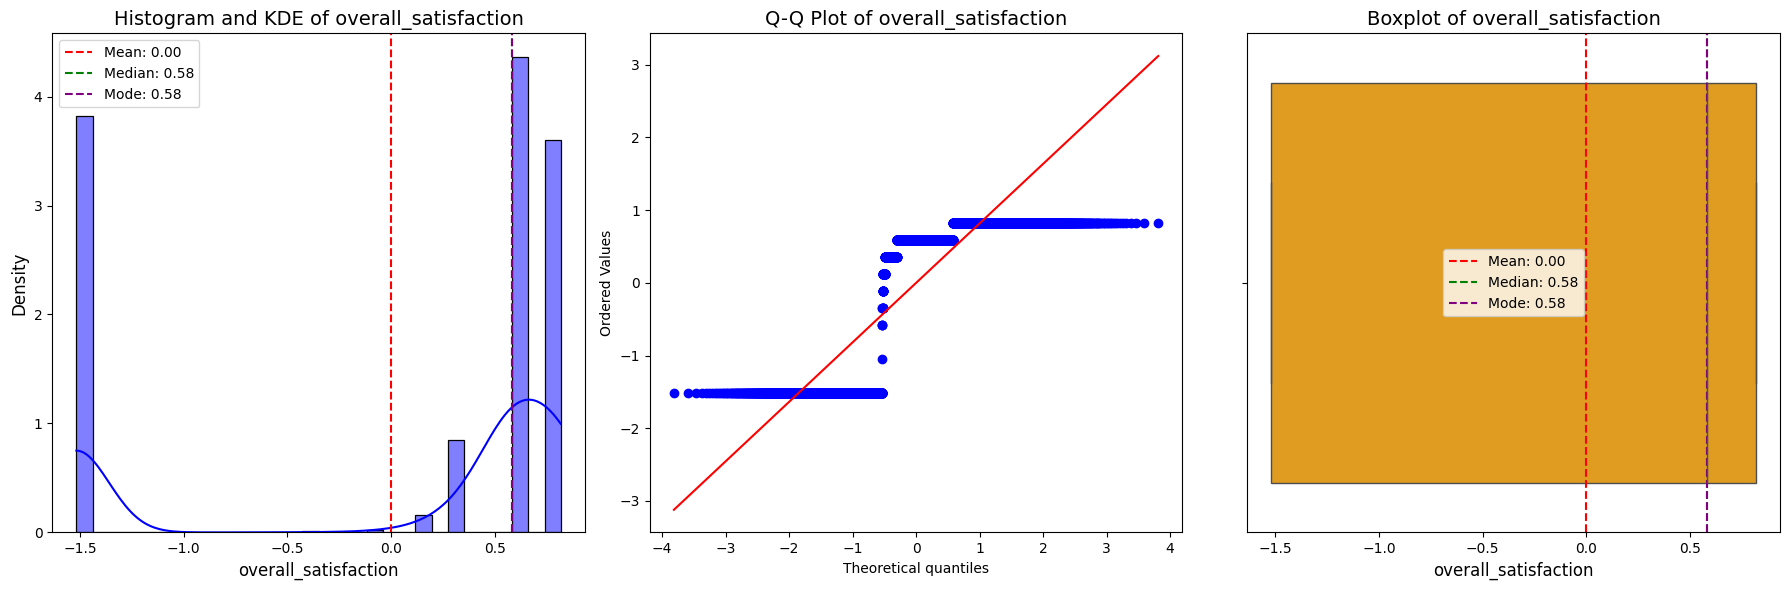


Normality Tests for Column: accommodates
Shapiro-Wilk Test: statistic=0.9016, p-value=0.0000
Kolmogorov-Smirnov Test: statistic=0.2063, p-value=0.0000


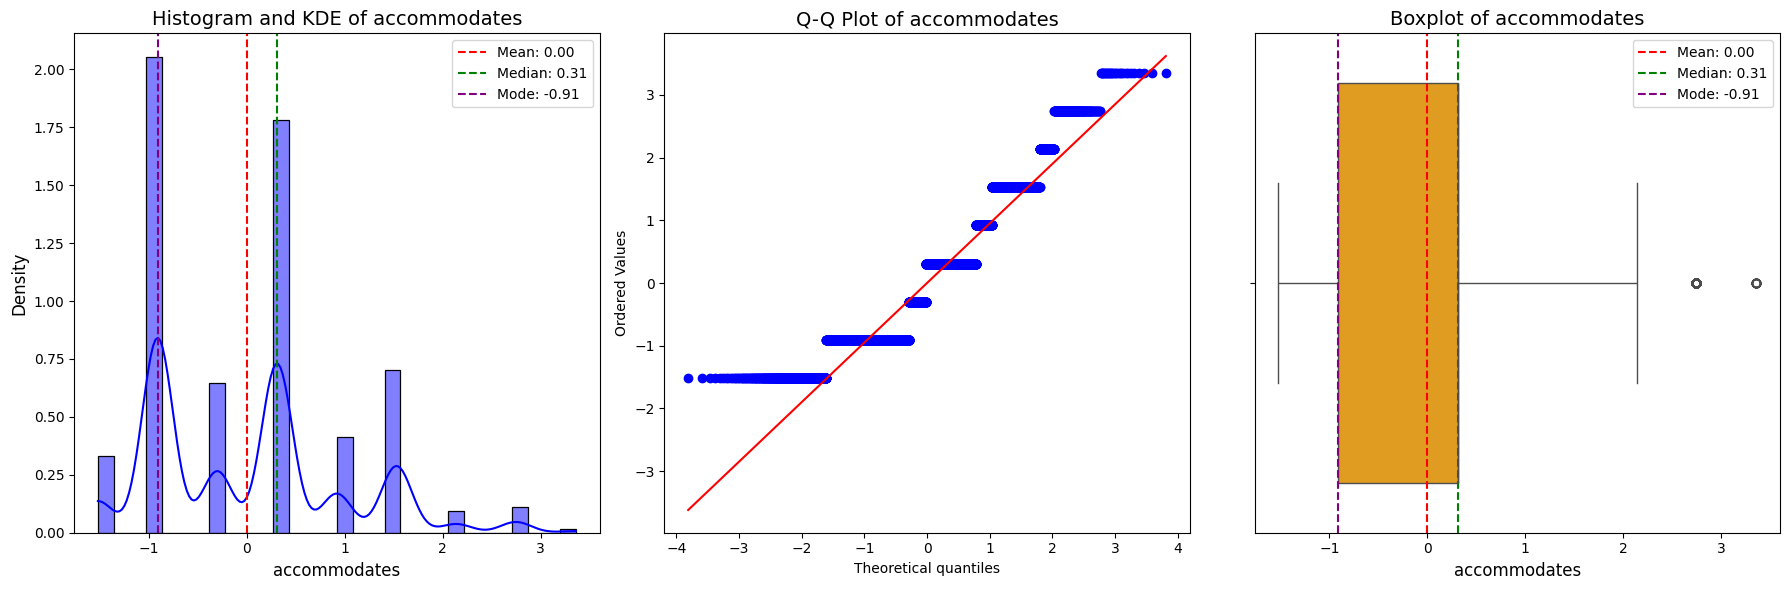


Normality Tests for Column: bedrooms
Shapiro-Wilk Test: statistic=0.7892, p-value=0.0000
Kolmogorov-Smirnov Test: statistic=0.3535, p-value=0.0000


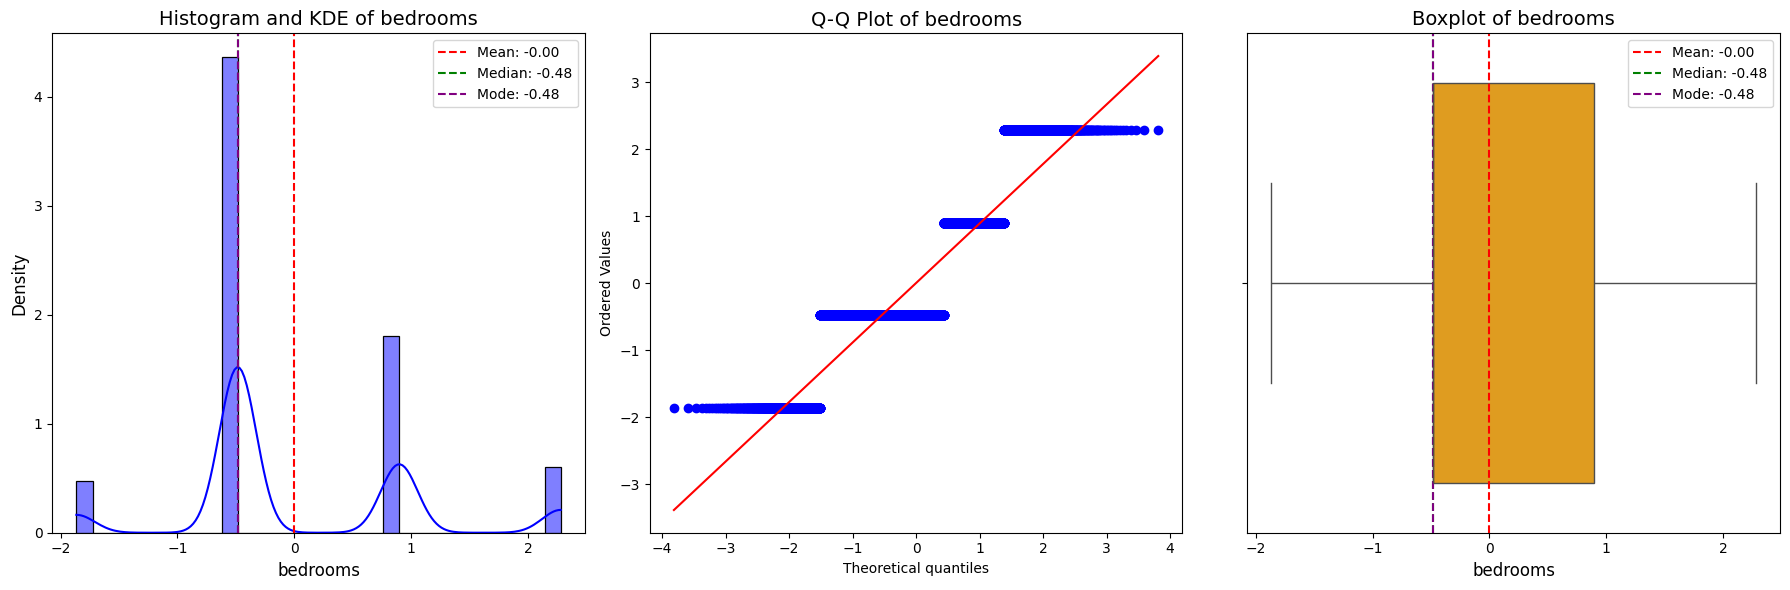


Normality Tests for Column: price
Shapiro-Wilk Test: statistic=0.9671, p-value=0.0000
Kolmogorov-Smirnov Test: statistic=0.0897, p-value=0.0000


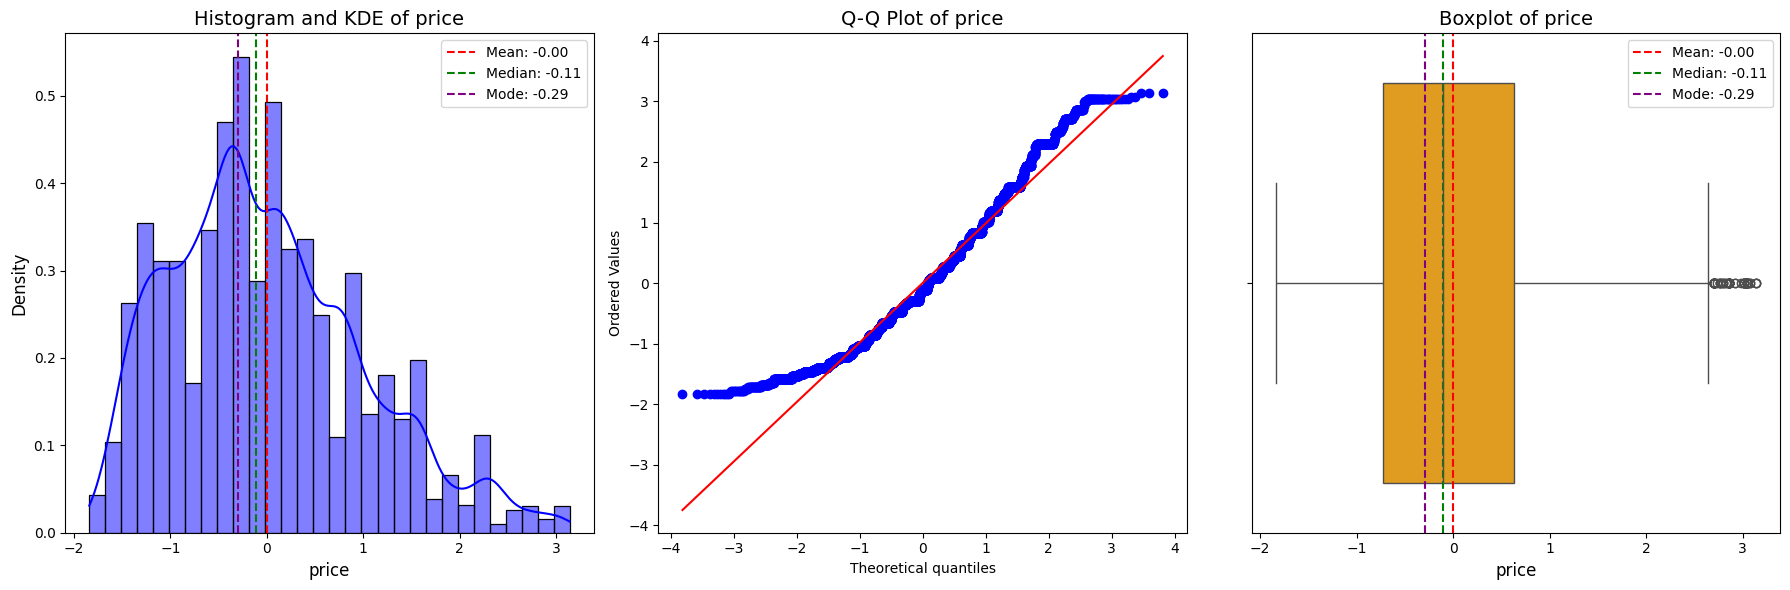


Normality Tests for Column: latitude
Shapiro-Wilk Test: statistic=0.9049, p-value=0.0000
Kolmogorov-Smirnov Test: statistic=0.1308, p-value=0.0000


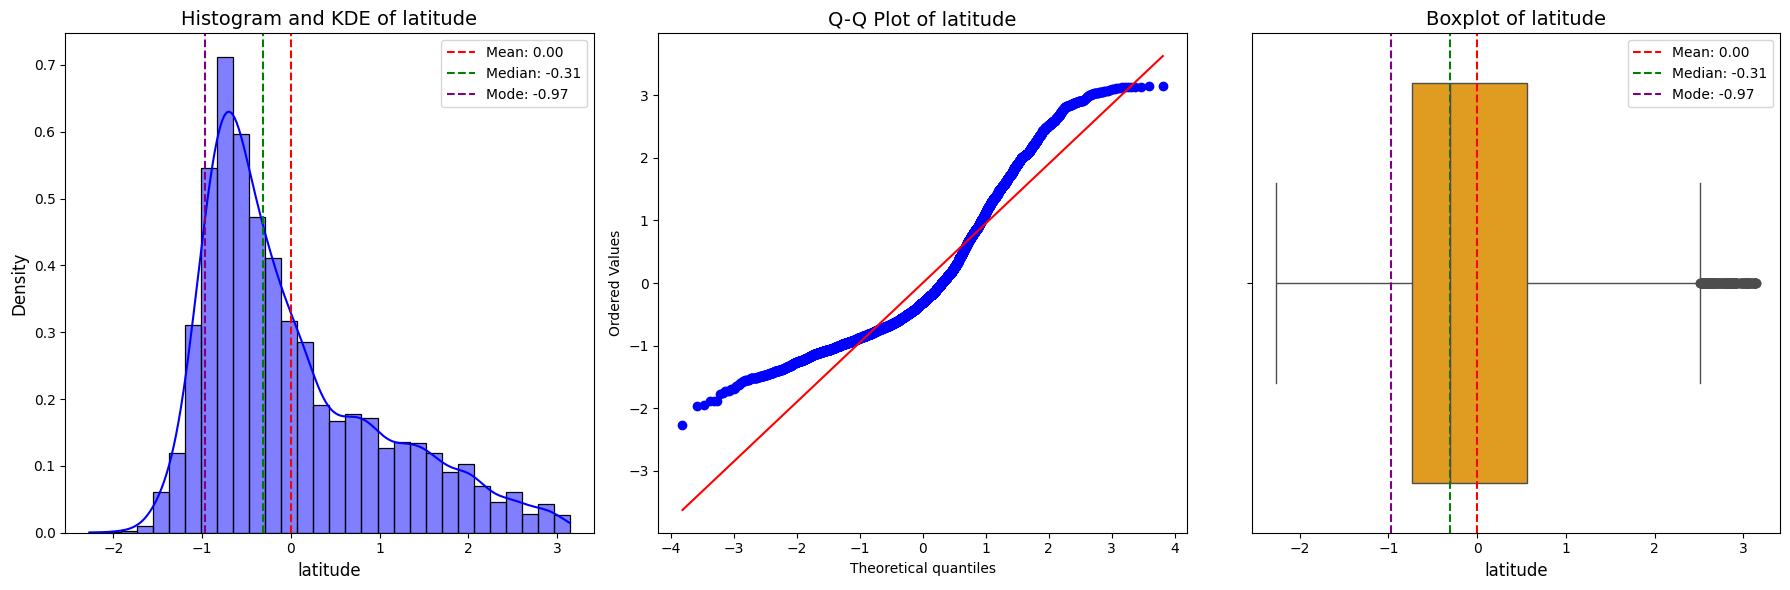


Normality Tests for Column: longitude
Shapiro-Wilk Test: statistic=0.9810, p-value=0.0000
Kolmogorov-Smirnov Test: statistic=0.0681, p-value=0.0000


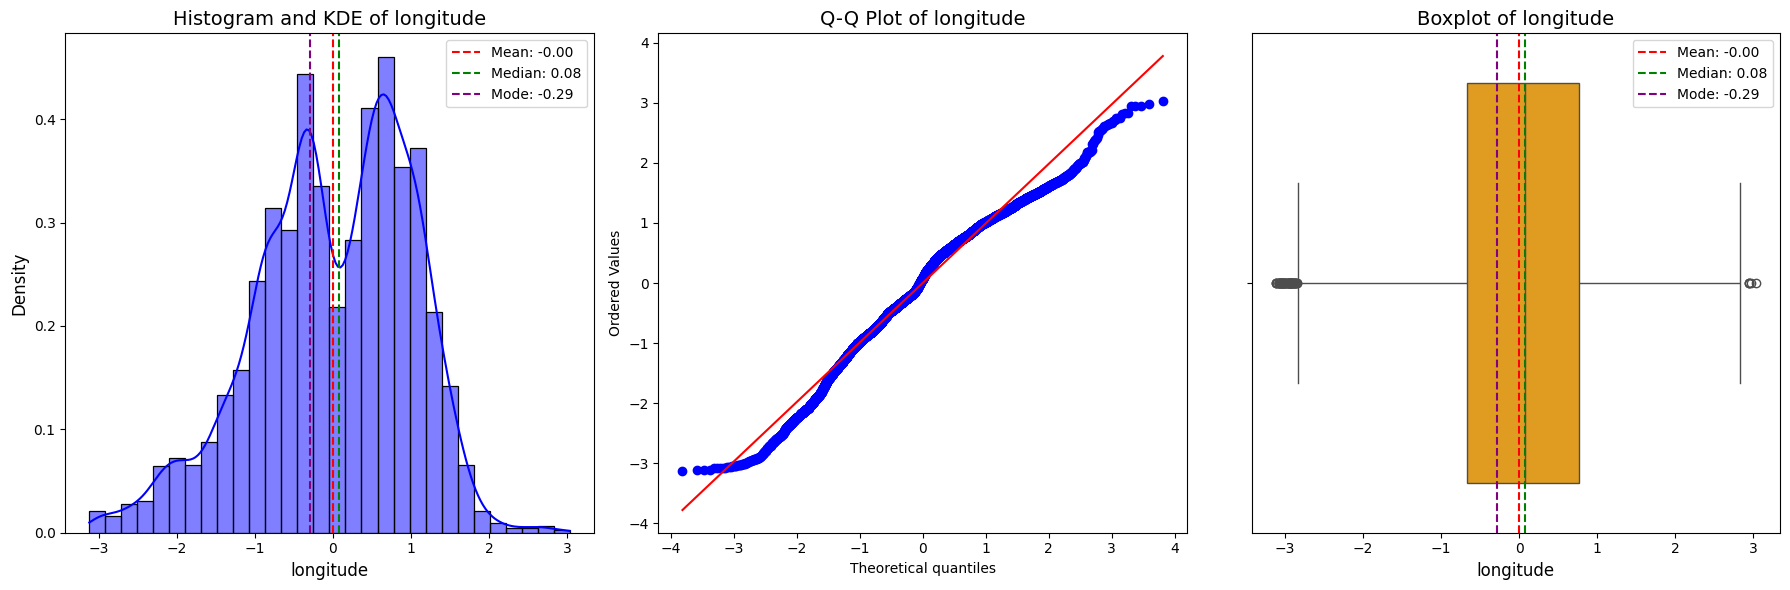


Normality Tests for Column: location
Shapiro-Wilk Test: statistic=0.9544, p-value=0.0000
Kolmogorov-Smirnov Test: statistic=0.0596, p-value=0.0000


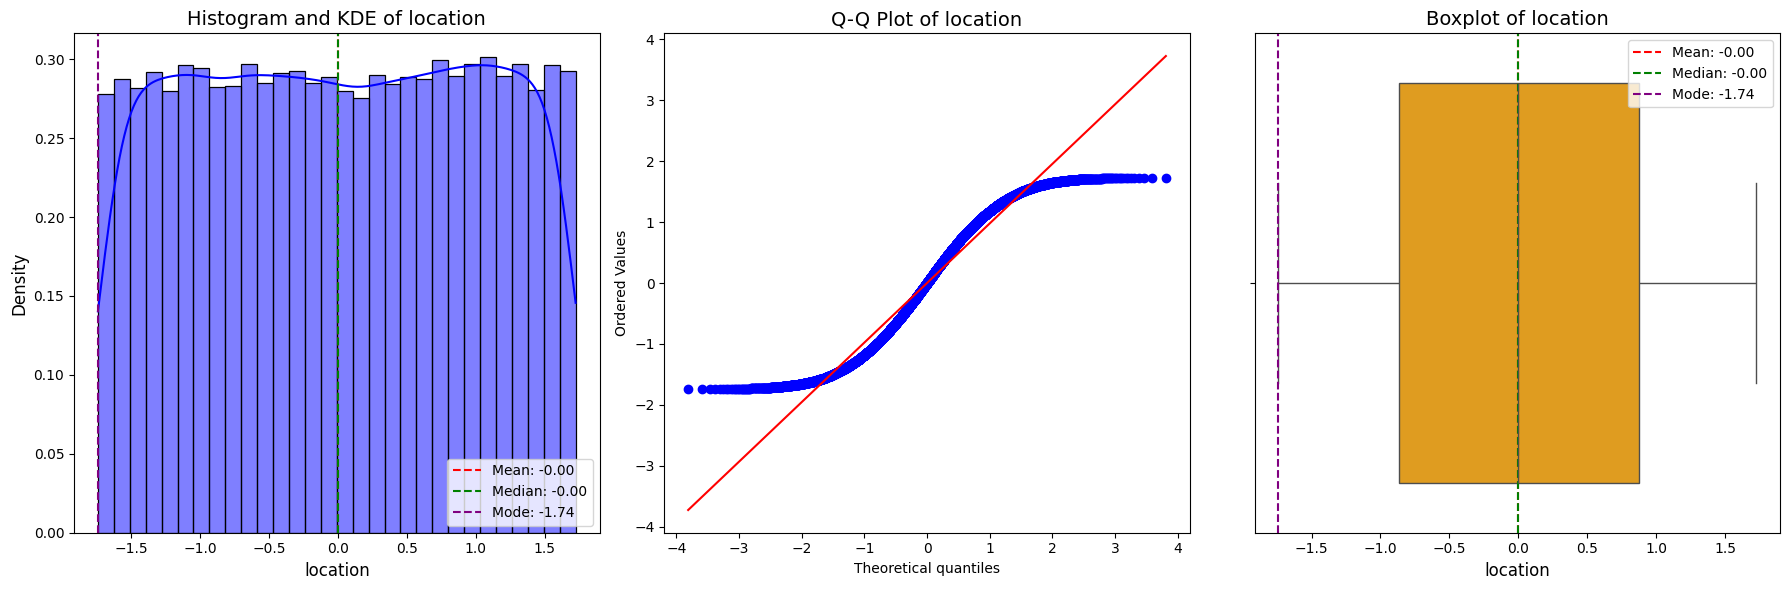

In [225]:
airbnb_data_prep.normality_test_with_plots()

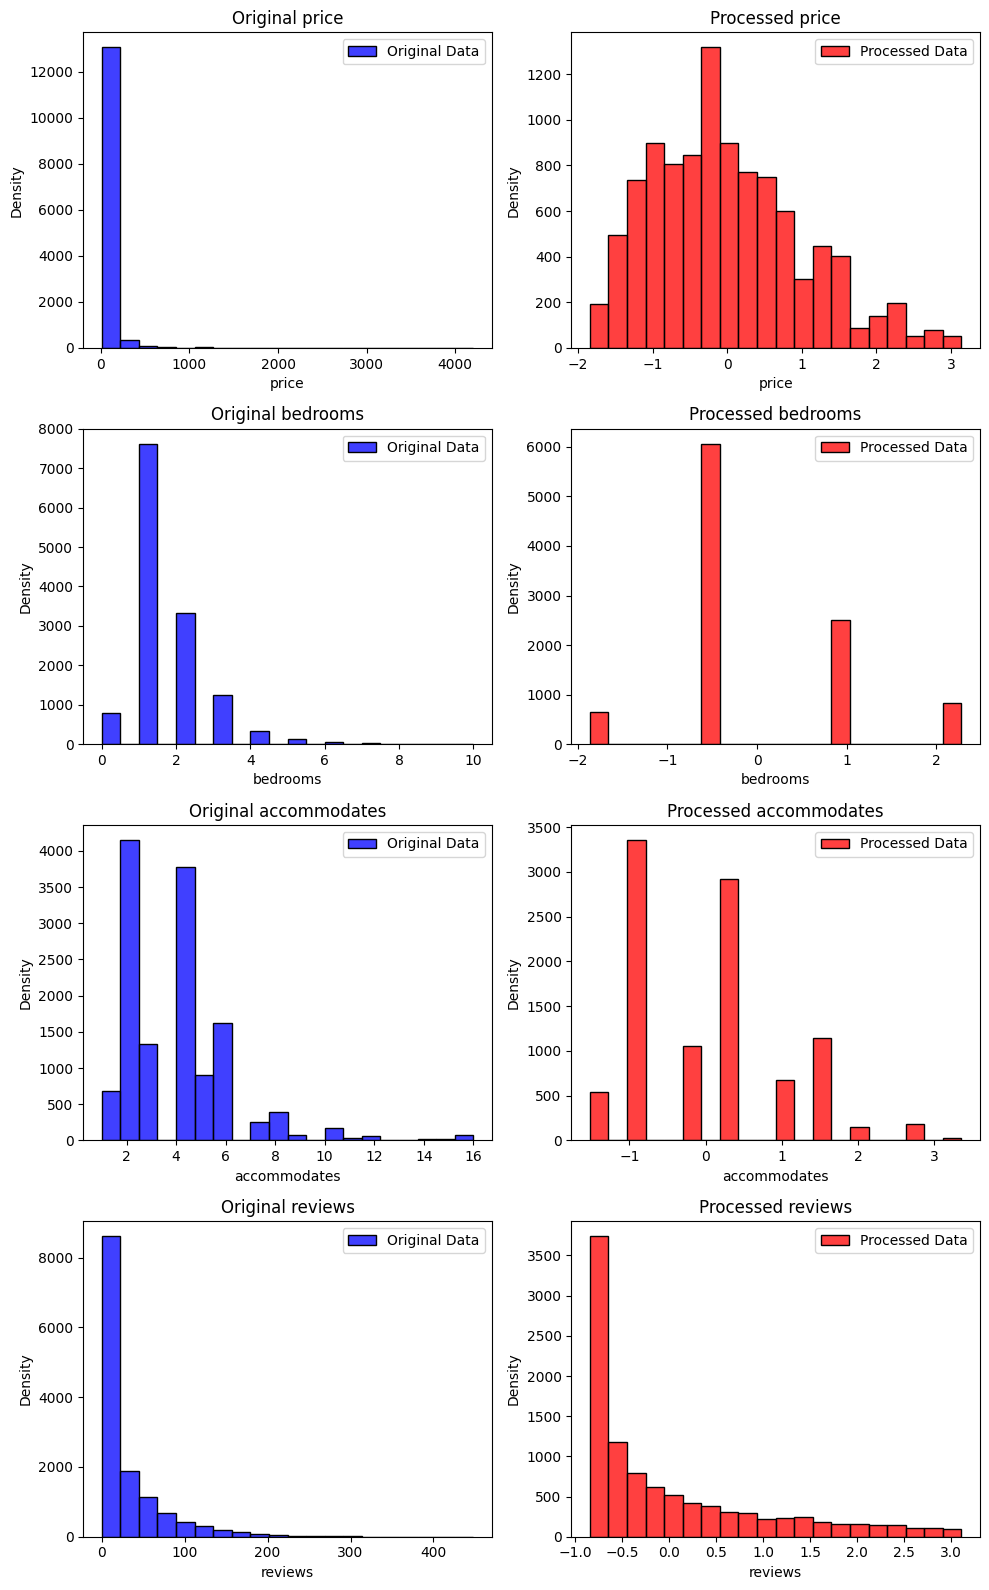

In [226]:
airbnb_data_prep.compare_data_state(columns=["price", "bedrooms", "accommodates","reviews"], bins=20, use_kde=False)

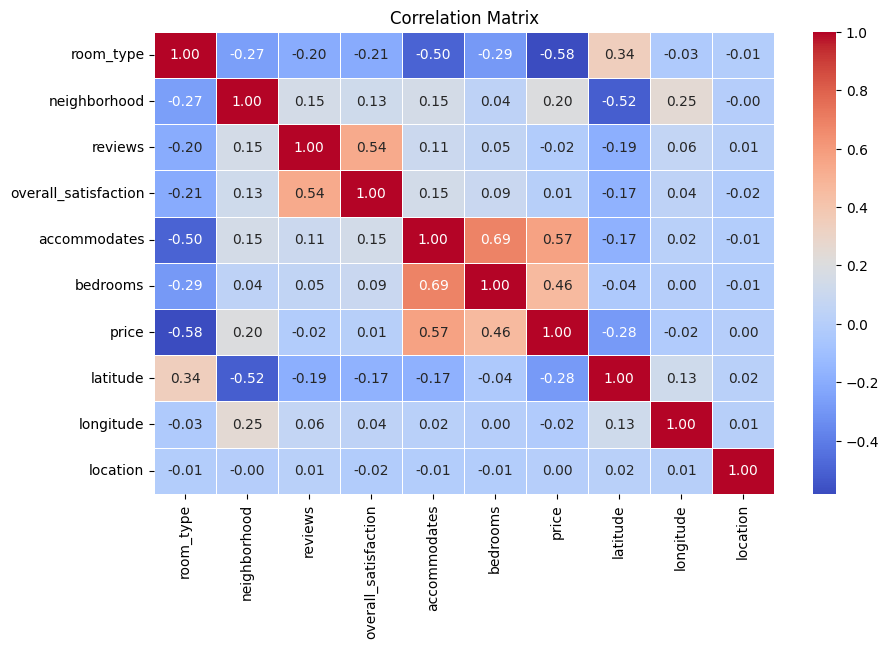

In [227]:
airbnb_data_prep.plot_correlation_matrix()

In [228]:
d_X, d_y = airbnb_data_prep.get_features_and_target()

autoML = AutoMLPipeline(LearningType.SUPERVISED, TargetMetric.RMSE)
autoML.train(d_X, d_y)

12682.61s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
12682.78s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
12682.95s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
12683.12s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00


Model Performance Summary:
                        Model     Score  Rank
2               Decision Tree -0.708342   1.0
1  Linear/Logistic Regression -0.706184   2.0
3      Support Vector Machine -0.685928   3.0
0               Random Forest -0.667911   4.0


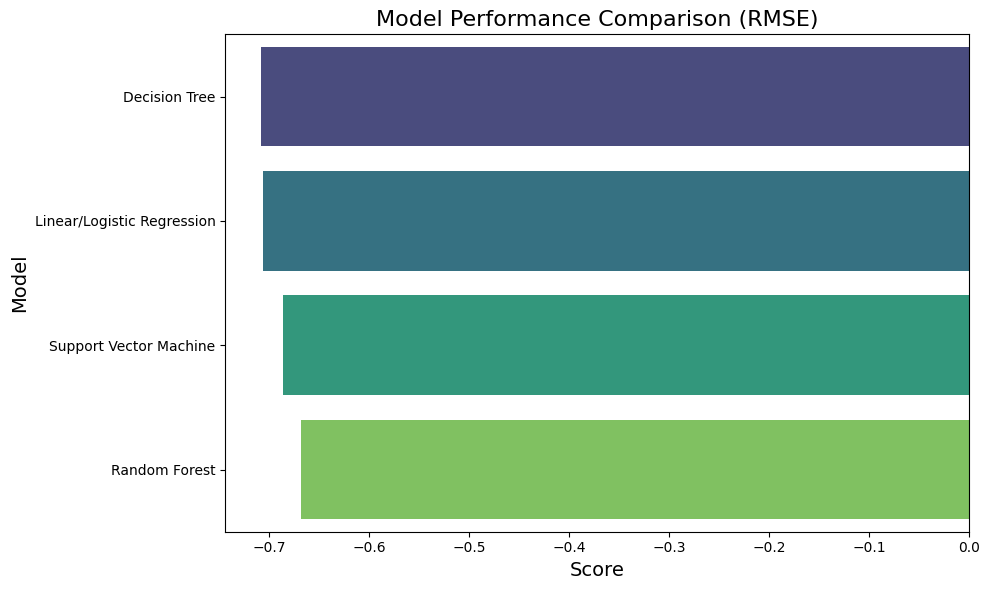


Best Model: Decision Tree with Score: -0.7083

Model: Random Forest | Score: -0.6679

Model: Linear/Logistic Regression | Score: -0.7062

Model: Decision Tree | Score: -0.7083

Model: Support Vector Machine | Score: -0.6859


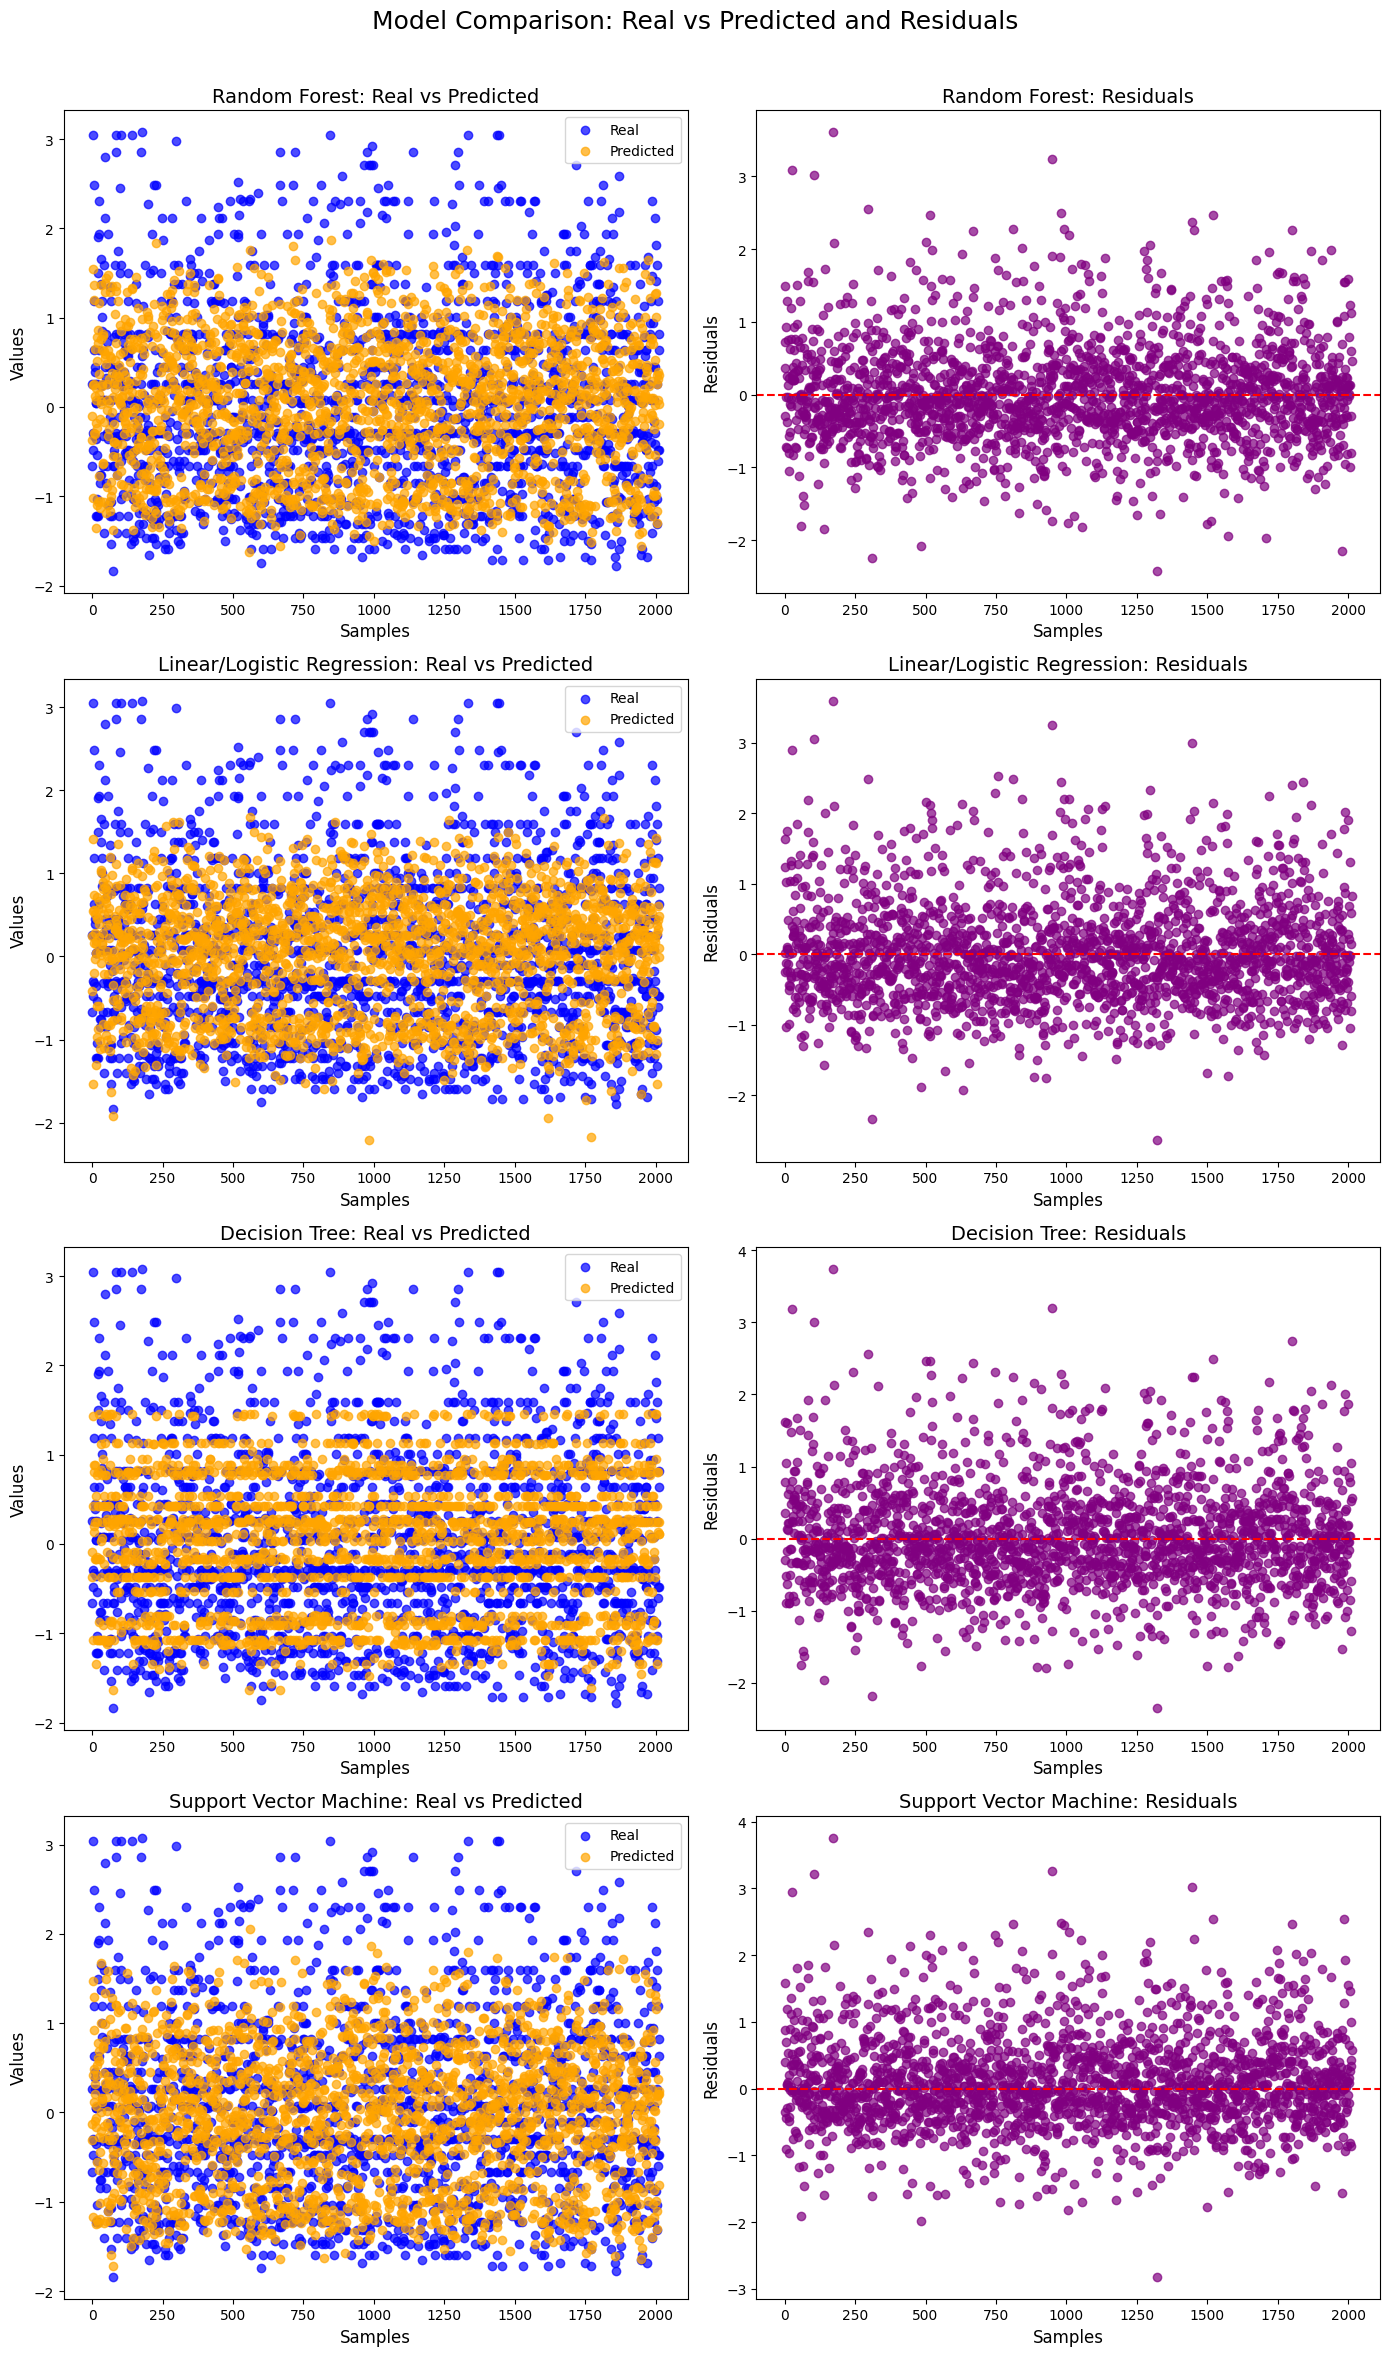

In [229]:
autoML.report()